# Multi-Label classification problem: Movie genres prediction based on their posters
### In this notebook i will be tackling multi-label prediction using images
### The First part of notebook will be exploratory data analysis
### The second part will be the modelling (The modelling decisions will be disscused in the section)
<hr style="width:60%;text-align:left;margin-left:0">

## Importing Neccessary Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Preprocessing

## Loading the Dataset

In [2]:
df = pd.read_csv('../input/movie-classifier/Multi_Label_dataset/train.csv')


In [3]:
# taking 35% of the total dataset: my laptop is not very good so anything more,crashes the training
selections = int(df.shape[0] * 0.35)
df = df.head(selections)




### Since i'm going to be only training and testing only on 35% of the data i will have to do some data cleaning to make sure that only the genres that are relevent to this subset of movies are used.

In [4]:
#Getting all genres in this section of the dataset
All_genres = df.columns
All_genres = All_genres[2:]
All_genres = list(All_genres)

### We Notice here that we have an N/A category which can potentially be dropped if it's always equal to 0 in the one hot encoding format

In [5]:
df[df['N/A']==1]

,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,N/A,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western


### We can safely drop it this column
### Let's also check if any other genres have the same problem

In [6]:
columns_to_be_dropped = []
for genre in All_genres:
    if df[df[genre]==1].shape[0] == 0:
        columns_to_be_dropped.append(genre)
if len(columns_to_be_dropped)>0 :
    print(f"{columns_to_be_dropped}: These columns were dropped because they're always equal to 0.")
    df = df.drop(columns=columns_to_be_dropped)
    for column in columns_to_be_dropped:
        All_genres.remove(column)


['N/A', 'News', 'Reality-TV']: These columns were dropped because they're always equal to 0.


In [7]:
NUMBER_OF_CLASSES = len(All_genres)
print(f"We have a multi-label classification problem with {NUMBER_OF_CLASSES} distinct classes !")

We have a multi-label classification problem with 22 distinct classes !


# Exploratory data analysis (EDA)
### Now that the data is cleaned and is actually in one-hot-encoding format we can perform some data analysis that can help us make better decisions when modelling

In [8]:
df.head()
df1 = df[All_genres]

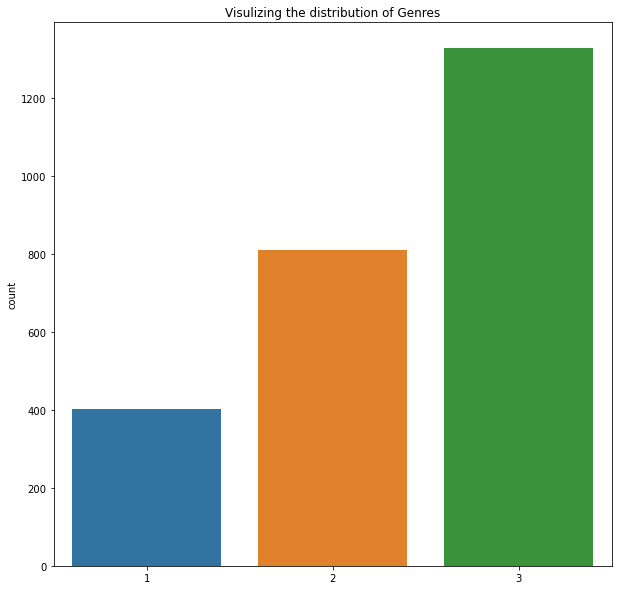

In [9]:
plt.figure(figsize=(10,10))
plt.title("Visulizing the distribution of Genres")
sns.countplot(df1.sum(axis=1))
plt.show()


#### Observations:
- In this dataset we only have movies that have genres ranging between : 1 genre to 3 genres.
- The number of movies with 2 genres or more is the majority therefore when modelling we need to choose an algorithm that can handle multi-label classification

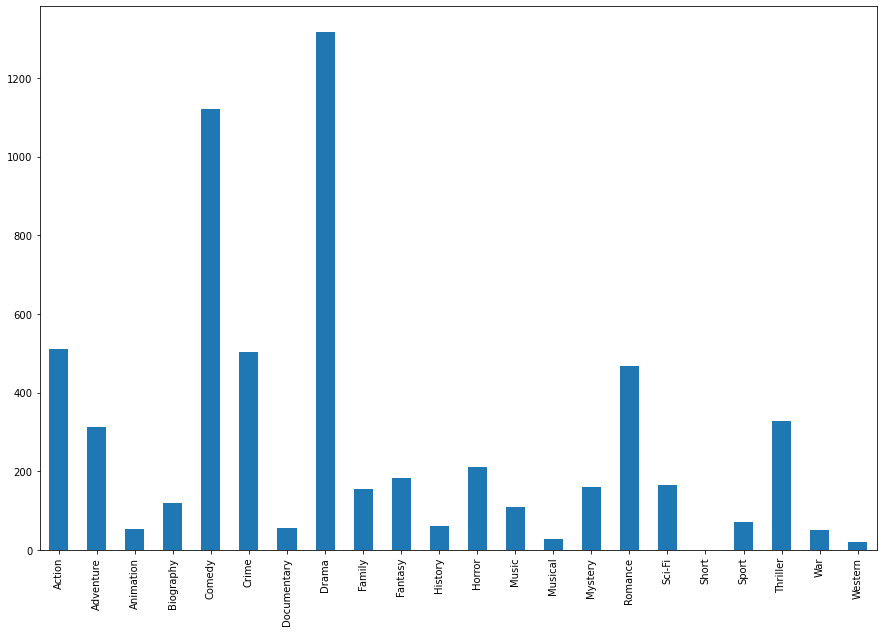

In [10]:
df1 = df[All_genres]
plt.figure(figsize=(15,10))

genre_counts = df1.sum(axis=0)
genre_counts.plot(kind='bar')
plt.show()


#### Observations:
- The classes are not balanced, we have some genres which occur most often then others such as Drama, Comedy and Action
- This is expected and in line with my intution since most people enjoy these types of movies, sometimes a combination of them.

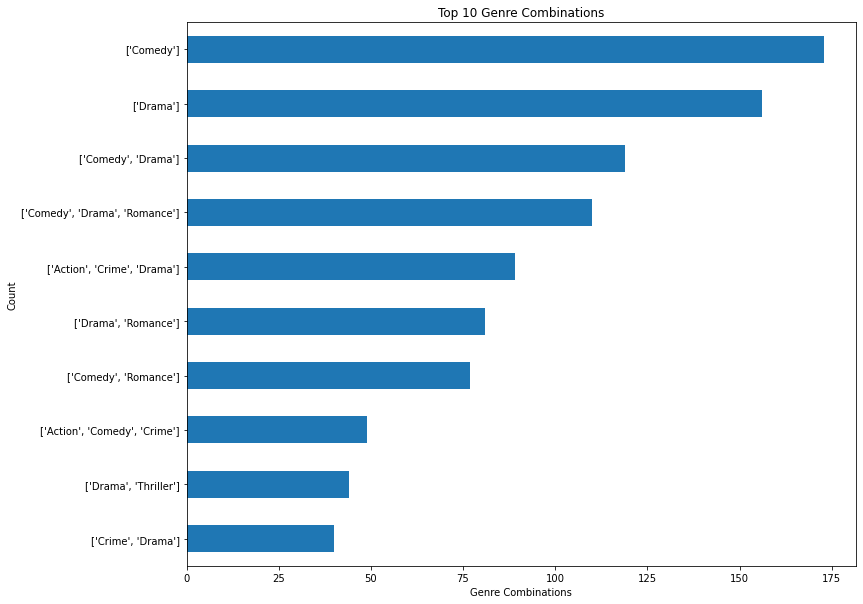

In [11]:
plt.figure(figsize=(12, 10))

df['Genre'].value_counts().head(10).plot(kind='barh')
plt.title('Top 10 Genre Combinations')
plt.ylabel('Count') 
plt.xlabel('Genre Combinations') 
plt.gca().invert_yaxis()  # To display the genre with the highest count at the top
plt.show()



#### Observations:
- The most popular movie genre is Comedy which makes sense, since this genre appeals to wider target audiences including families,casual movie enjoyers and dedicated critics
- The seconds popular movie genre is Drama which was also expected
- Other popular choises include a combination of comedy,drama and at some other genres

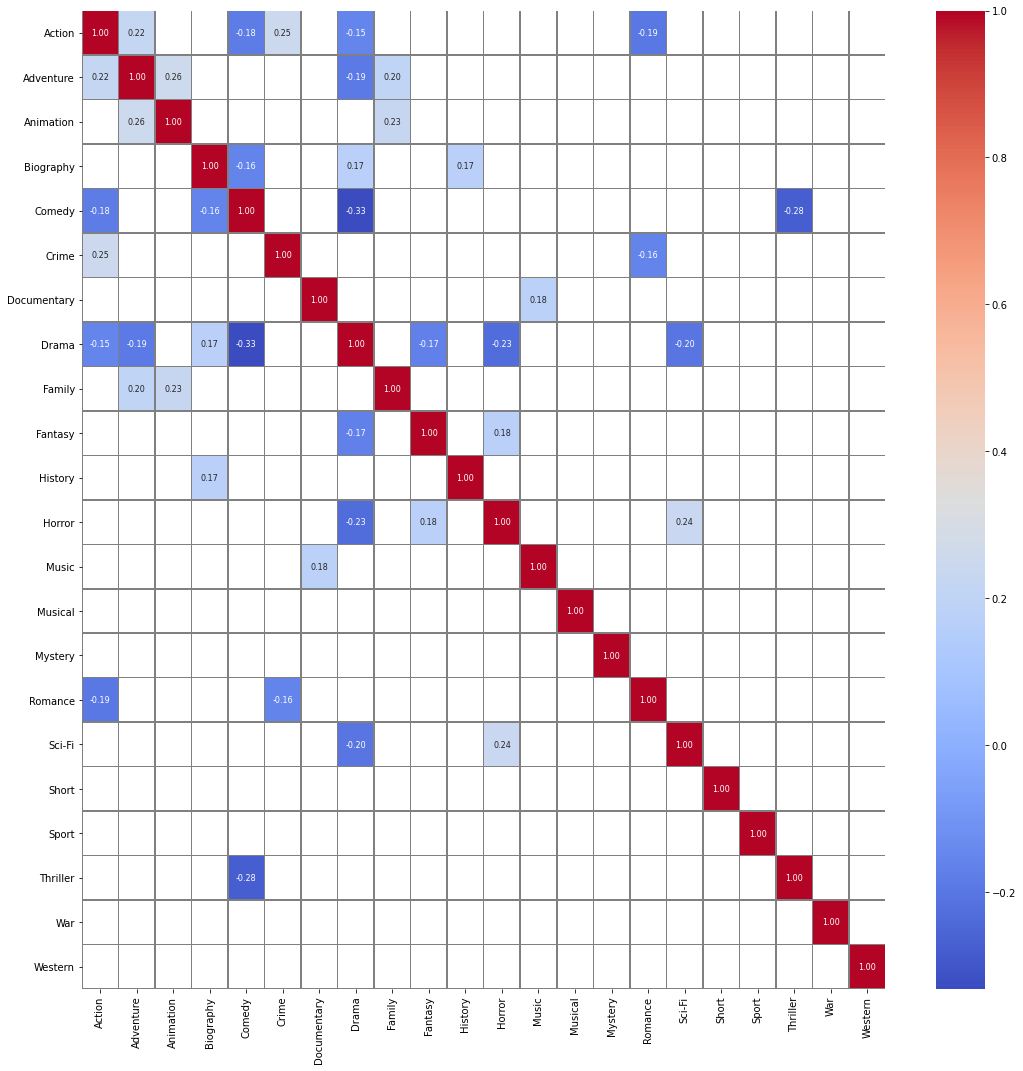

In [12]:

correlation_matrix = df1.corr(method='pearson')

# Mask for displaying only correlations above a certain absolute value
mask = np.abs(correlation_matrix) < 0.15

plt.figure(figsize=(18,18))

# Heatmap with masked values, smaller annotations, 'coolwarm' colormap, and a prominent grid
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, annot_kws={'size': 8}, linewidths=0.5, linecolor='grey')

plt.show()


#### Observations:
- Movie genres don't exist in a vaccume and are in fact very correlated so knowing a particular category can in fact carry some information about a potential other genre:
<br>For Example :
* Comedy and Drama seem to be negatively correlated because it's hard to be dramatic/emotional while being funny


# Modelling:
- We are going to be using movie posters to predict the genres that correspond to it 
- One option for this type of problem is to use a binary classifier for each of the genres so in this case we can train 22 models and finally aggregate the predicted genres
- Using this appoarch while in theory can work is not ideal because as we've seen from our EDA that movie genres are corrolated and this approach assumes indepence of so it will ignore any mutal information that can be learned by observing a particular movie genre

+ Another approach could be using CNN neural networks but there's a Caveat -> At the final layer we can't use the softmax activation function because this function assumes indepence between labels and this not what we want.
+ We want the neural network to learn the relationship between the labels too, so using a sigmoid activation function in this case might be the best approach


# Convolutional Neural Networks (CNNs):
CNNs, or Convolutional Neural Networks, are a class of deep learning models primarily used for analyzing visual data. They are especially good at recognizing patterns in images due to their specialized architecture, which includes:<br>

<b>Convolutional layers:</b> Scan an image with small filters to detect local patterns.<br>
<b>Pooling layers:</b> Reduce the spatial dimensions while preserving significant information.<br>
<b>Fully connected layers:</b> Make predictions or classifications based on the extracted features.<br>
In essence, CNNs transform raw image data through multiple layers to detect features, from simple edges to complex patterns, which are then used for tasks like image classification, object detection, and more.

## Data Preparation for CNNs
### 1- Resizing the images (since not all posters have the same dimentions)
### 2- Transforming them into Numpy array (These can serve as an input to our CNNs
### 3- Normalizing them to train the CNN (ANNs in general performs best when the features are between 0 and 1 the reason for this is to avoid exploding or vanishing gradients, since Neural networks are trained using gradient descent) 

In [13]:
WIDTH = 200
HEIGHT = 200
# While bigger images can probably capture more details and get performance,I'm limited with the computational power of my laptop.


def create_X_features_from_Images(width,height):
    X = []
    for i in tqdm(range(df.shape[0])):
        path = '../input/movie-classifier/Multi_Label_dataset/Images/'+df['Id'][i]+'.jpg'
        # first we load the image and then resize it to be width x height
        img = image.load_img(path,target_size=(width,height,3))        #3 here refers to the number of channels R,G,B
        # Next we normalize it by deviding by 255 (since it's in RGB format)
        img = image.img_to_array(img)
        img = img/255.0
        X.append(img)
    return np.array(X)

X = create_X_features_from_Images(WIDTH,HEIGHT)

100%|██████████| 2538/2538 [00:27<00:00, 90.89it/s]


In [14]:
X.shape

(2538, 200, 200, 3)

### Our data is now ready to be fed into our CNNs for training
### The labels are in one-hot-encoding format

In [15]:
y = df.drop(['Id','Genre'],axis=1)
y = y.to_numpy()
y.shape

(2538, 22)

### We Split the data into trainig and testing:
### I will use an 80% , 20% split which is quite standard

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

# Preparing the model
### I will also be using Data Augmentation to artificially increase the size of your training dataset by creating modified versions of images in the dataset. This helps in preventing overfitting and can lead to better generalization in neural network models.
### In this case i will use ImageDataGenerator Object from Keras with the following parameters:

- rotation_range=30: Randomly rotates the image between -30 and +30 degrees.

- zoom_range=0.2: Randomly zooms the image in and out by a factor between (1-0.2) and (1+0.2), or between 80% and 120% zoom.

- width_shift_range=0.25: Randomly shifts the image horizontally by a fraction of its width. The shift ranges between -25% to +25% of the image width.

- height_shift_range=0.25: Randomly shifts the image vertically by a fraction of its height. The shift ranges between -25% to +25% of the image height.

- shear_range=0.20: Applies a random shear transformation by an angle of -0.20 to +0.20 radians.

- horizontal_flip=True: Randomly flips the image horizontally.

- fill_mode="nearest": Method to fill the empty pixels created by some of the transformations, like rotation. It fills the new pixels by their nearest neighbors' values.


In [17]:
NUMBER_OF_CLASSES = 22
BatchSize = 64
NUMBER_OF_EPOCHS = 10


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers


# Parameters for the model
INPUT_SHAPE = (WIDTH, HEIGHT, 3)  
FILTER_SIZE = (3, 3)  # Typical filter size for CNNs
POOL_SIZE = (2, 2)  # Typical pooling size

# Create the model
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(32, FILTER_SIZE, activation='relu', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=POOL_SIZE))

# Convolutional Layer 2
model.add(Conv2D(64, FILTER_SIZE, activation='relu'))
model.add(MaxPooling2D(pool_size=POOL_SIZE))

# Convolutional Layer 3
model.add(Conv2D(128, FILTER_SIZE, activation='relu'))
model.add(MaxPooling2D(pool_size=POOL_SIZE))

# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUMBER_OF_CLASSES, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# construct the training image generator for data augmentation

aug = ImageDataGenerator(rotation_range=30, zoom_range=0.2,width_shift_range=0.25, height_shift_range=0.25, 
                         shear_range=0.20,horizontal_flip=True, fill_mode="nearest")


Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 67712)            

In [18]:

history1 = model.fit_generator(aug.flow(X_train, y_train, batch_size=BatchSize),validation_data=(X_test, y_test), 
                    steps_per_epoch=len(X_train) // BatchSize, epochs=NUMBER_OF_EPOCHS)

Epoch 1/10
31/31 [==============================] - 19s 614ms/step - loss: 0.3513 - accuracy: 0.8776 - val_loss: 0.2813 - val_accuracy: 0.8969
Epoch 2/10
31/31 [==============================] - 16s 521ms/step - loss: 0.2724 - accuracy: 0.8950 - val_loss: 0.2621 - val_accuracy: 0.8984
Epoch 3/10
31/31 [==============================] - 17s 545ms/step - loss: 0.2654 - accuracy: 0.8989 - val_loss: 0.2599 - val_accuracy: 0.9001
Epoch 4/10
31/31 [==============================] - 16s 524ms/step - loss: 0.2652 - accuracy: 0.8976 - val_loss: 0.2579 - val_accuracy: 0.9017
Epoch 5/10
31/31 [==============================] - 17s 545ms/step - loss: 0.2634 - accuracy: 0.8992 - val_loss: 0.2578 - val_accuracy: 0.9017
Epoch 6/10
31/31 [==============================] - 16s 518ms/step - loss: 0.2614 - accuracy: 0.9004 - val_loss: 0.2573 - val_accuracy: 0.9002
Epoch 7/10
31/31 [==============================] - 17s 544ms/step - loss: 0.2613 - accuracy: 0.9000 - val_loss: 0.2626 - val_accuracy: 0.8974

# Transfer learning approach:

Transfer learning is a machine learning technique where a model developed for one task is reused as the starting point for a model on a second task. Essentially, it involves taking a pre-trained neural network and adapting its architecture and weights to a new, yet similar, task.
Transfer learning is particularly valuable in deep learning due to the substantial computational power and time required to train deep neural networks. It can be advantageous in scenarios where the dataset for the new task is limited in size, and training a deep model from scratch may result in overfitting.

### <b>A classic example of Transfer Learning using the VGG16 architecture:</b>
#### the VGG16 model, a widely-used deep convolutional network is trained on millions of images from the ImageNet dataset.



## Advantages compared to a generic CNN:
- Feature Richness: The VGG16 convolutional base has already learned a vast amount of features from the ImageNet dataset. These features, which can be edges, textures, patterns, etc., are beneficial and can be reused for many image classification tasks.

- Training Efficiency: By using pre-trained weights and freezing some layers, you drastically reduce the number of trainable parameters. This can lead to faster training times and less data requirement.

- Performance: Transfer learning often results in better performance, especially when the original dataset (ImageNet, in this case) has similarities or shares common features with your target dataset. Leveraging the knowledge learned from a vast dataset can lead to better generalization in many scenarios.

- Avoiding Overfitting: If you don't have a huge dataset, training a large model from scratch can lead to overfitting. By using a pre-trained model, you leverage previously learned features, which often reduces the risk of overfitting, especially when combined with techniques like dropout.

In [19]:
from keras.applications import VGG16


#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Freeze the layers except the last 5 layers
for layer in vgg_conv.layers[:-5]:
    layer.trainable = False

# Create the model
model = Sequential()


# Add the vgg convolutional base model
model.add(vgg_conv)


# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUMBER_OF_CLASSES, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, zoom_range=0.2,width_shift_range=0.25, height_shift_range=0.25, 
                         shear_range=0.20,horizontal_flip=True, fill_mode="nearest")


58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              18875392  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 22)                22550     
Total params: 33,612,630
Trainable params: 25,977,366
Non-trainable params: 7,635,264
_________________________________________________________________


In [20]:

history2 = model.fit_generator(aug.flow(X_train, y_train, batch_size=BatchSize),validation_data=(X_test, y_test), 
                    steps_per_epoch=len(X_train) // BatchSize, epochs=NUMBER_OF_EPOCHS)

Epoch 1/10
31/31 [==============================] - 21s 684ms/step - loss: 0.3279 - accuracy: 0.8758 - val_loss: 0.2706 - val_accuracy: 0.8967
Epoch 2/10
31/31 [==============================] - 19s 622ms/step - loss: 0.2770 - accuracy: 0.8931 - val_loss: 0.2689 - val_accuracy: 0.8925
Epoch 3/10
31/31 [==============================] - 18s 594ms/step - loss: 0.2748 - accuracy: 0.8941 - val_loss: 0.2685 - val_accuracy: 0.8969
Epoch 4/10
31/31 [==============================] - 19s 619ms/step - loss: 0.2680 - accuracy: 0.8982 - val_loss: 0.2825 - val_accuracy: 0.8937
Epoch 5/10
31/31 [==============================] - 19s 600ms/step - loss: 0.2698 - accuracy: 0.8981 - val_loss: 0.2687 - val_accuracy: 0.8961
Epoch 6/10
31/31 [==============================] - 18s 587ms/step - loss: 0.2639 - accuracy: 0.9018 - val_loss: 0.2587 - val_accuracy: 0.9027
Epoch 7/10
31/31 [==============================] - 19s 599ms/step - loss: 0.2606 - accuracy: 0.9033 - val_loss: 0.2588 - val_accuracy: 0.9035

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

def plotLearningCurve(history, epochs, title="Learning Curves"):
    epochRange = range(1, epochs+1)
    
    # Define a custom color palette
    palette = ["#3498db", "#e74c3c"]
    
    # Set the style of Seaborn and context for better clarity
    sns.set_style("darkgrid")
    sns.set_context("talk")
    
    # Create a figure with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(17,6))
    
    # Plot accuracy
    sns.lineplot(x=epochRange, y=history.history['accuracy'], ax=axs[0], label='Train', palette=palette, linewidth=2.5, estimator=None)
    sns.lineplot(x=epochRange, y=history.history['val_accuracy'], ax=axs[0], label='Validation', palette=palette, linewidth=2.5, linestyle='--', estimator=None)
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')
    
    # Plot loss
    sns.lineplot(x=epochRange, y=history.history['loss'], ax=axs[1], label='Train', palette=palette, linewidth=2.5, estimator=None)
    sns.lineplot(x=epochRange, y=history.history['val_loss'], ax=axs[1], label='Validation', palette=palette, linewidth=2.5, linestyle='--', estimator=None)
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='upper right')
    
    # Set main title for the entire figure and underline it
    suptitle = fig.suptitle(title, fontsize=18, y=1.05)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)  # Make space for the suptitle
    plt.show()



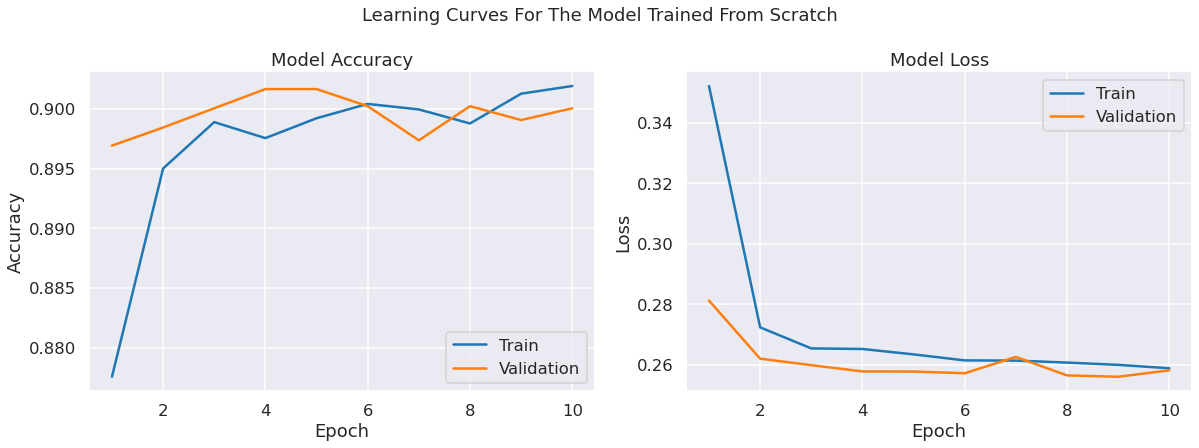

In [22]:
plotLearningCurve(history1,NUMBER_OF_EPOCHS,"Learning Curves For The Model Trained From Scratch")

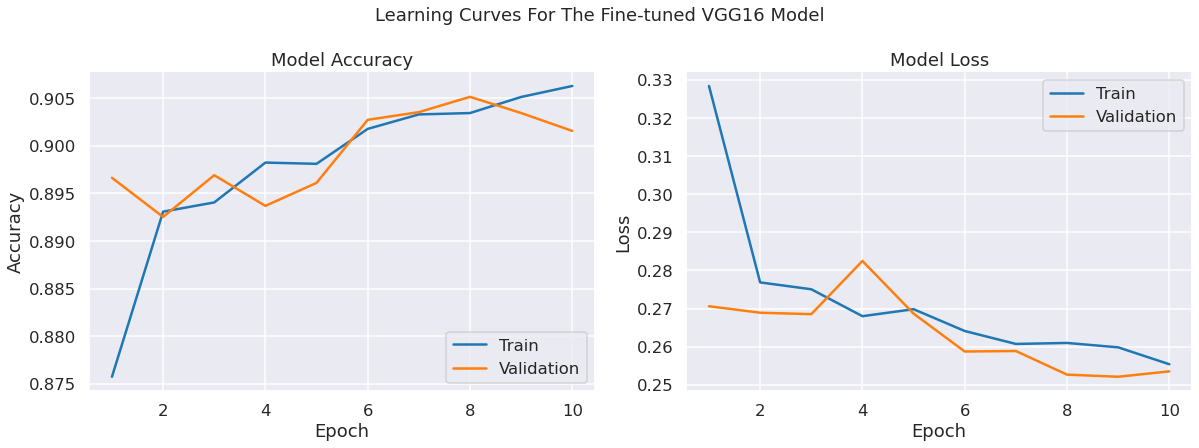

In [23]:
plotLearningCurve(history2,NUMBER_OF_EPOCHS,"Learning Curves For The Fine-tuned VGG16 Model")

# Conclusions:
### In This notebook I was able to create a Multi-label classifier using 2 approaches
### Both of them performed reall well with an accuracy of 90%
### Using transfer learning although cut the number of trainable parameters by more than half did not yiled significantly superior results


Credits to KRUTARTH DARJI, i used some of his code as a starting point for loading the dataset (images)